# Customer Churn Notebook Simplified

In [59]:
# librairies loading 
import os

import pandas as pd
import numpy as np

import scipy.stats as stats
import statsmodels.api as sm #qq-plot
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# just to conserve what I want

# 1-) Data Inspection

In [60]:
# dataset loading
notebooks_path = os.getcwd()
data_path = os.path.join(notebooks_path, "../data/raw_data/training.csv")

data_train = pd.read_csv(data_path, 
                        sep = ',',
                        header = 0)

print(data_train.shape)
data_train.head(10)

(11981, 19)


,CUSTOMER_ID,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURNED
0,C100000,zero,660.000000,19995.0,0,0,897338.0,False,4,3,160.0,155,1,1.2,15,very_unsat,little,considering,STAY
1,C100001,one,317.647059,31477.0,155,15,393396.0,True,0,1,100.0,245,27,2.7,4,unsat,little,considering,LEAVE
2,C100006,zero,208.695652,66742.0,0,13,937197.0,False,4,2,127.0,493,20,2.6,4,avg,very_little,considering,STAY
3,C100008,zero,265.017668,40864.0,183,0,986430.0,False,3,3,86.0,390,13,2.5,12,unsat,very_high,considering,LEAVE
4,C100010,one,440.000000,43321.5,200,0,394622.0,True,2,3,77.0,175,18,2.4,10,very_unsat,little,actively_looking_into_it,LEAVE
5,C100011,one,840.000000,18786.5,0,15,475819.0,True,1,2,143.0,187,0,3.8,4,very_unsat,very_high,actively_looking_into_it,STAY
6,C100012,zero,264.000000,46515.5,0,15,150498.0,True,3,1,191.0,363,1,3.2,4,very_unsat,very_high,never_thought,STAY
7,C100013,one,141.065831,90444.5,168,37,183605.0,True,5,3,217.0,539,28,2.0,2,very_sat,very_high,no,STAY
8,C100014,zero,483.870968,94779.5,179,0,677946.0,False,1,2,204.0,208,23,2.5,11,very_unsat,high,considering,LEAVE
9,C100015,one,276.315789,64602.5,204,24,270004.0,True,0,1,167.0,313,16,1.8,4,very_unsat,little,considering,STAY


In [3]:
# data structure
 
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11981 entries, 0 to 11980
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CUSTOMER_ID                  11981 non-null  object 
 1   COLLEGE                      11981 non-null  object 
 2   DATA                         11981 non-null  float64
 3   INCOME                       11981 non-null  float64
 4   OVERCHARGE                   11981 non-null  int64  
 5   LEFTOVER                     11981 non-null  int64  
 6   HOUSE                        11346 non-null  float64
 7   LESSTHAN600k                 11346 non-null  object 
 8   CHILD                        11981 non-null  int64  
 9   JOB_CLASS                    11981 non-null  int64  
 10  REVENUE                      11981 non-null  float64
 11  HANDSET_PRICE                11981 non-null  int64  
 12  OVER_15MINS_CALLS_PER_MONTH  11981 non-null  int64  
 13  TIME_CLIENT     

In [4]:
pd.isnull(data_train).sum()

CUSTOMER_ID                      0
COLLEGE                          0
DATA                             0
INCOME                           0
OVERCHARGE                       0
LEFTOVER                         0
HOUSE                          635
LESSTHAN600k                   635
CHILD                            0
JOB_CLASS                        0
REVENUE                          0
HANDSET_PRICE                    0
OVER_15MINS_CALLS_PER_MONTH      0
TIME_CLIENT                      0
AVERAGE_CALL_DURATION            0
REPORTED_SATISFACTION            0
REPORTED_USAGE_LEVEL             0
CONSIDERING_CHANGE_OF_PLAN       0
CHURNED                          0
dtype: int64

In [26]:
# features repartition

all_categorical_variables = [
 'COLLEGE',
 'LESSTHAN600k',
 'JOB_CLASS',
 'REPORTED_SATISFACTION',
 'REPORTED_USAGE_LEVEL',
 'CONSIDERING_CHANGE_OF_PLAN',
 'CHURNED']

numerical_variables = [
 'DATA',
 'INCOME',
 'OVERCHARGE',
 'LEFTOVER',
 'HOUSE',
 'CHILD',
 'REVENUE',
 'HANDSET_PRICE',
 'OVER_15MINS_CALLS_PER_MONTH',
 'TIME_CLIENT',
 'AVERAGE_CALL_DURATION']

# 2-) Visualization and preprocessing

## 2-1) Visualization

In [33]:
# catgoricals variables
categoricals_variables = [element for element in all_categorical_variables if element != "CHURNED"]

data_train["JOB_CLASS"] = data_train["JOB_CLASS"].astype("category")
for var in categoricals_variables :
        counts = data_train.groupby([var, 'CHURNED']).size().reset_index(name='count')
        total_per_college = counts.groupby(var)['count'].transform('sum')
        counts['percent'] = round(counts['count'] / total_per_college * 100, ndigits= 2)

        fig = px.histogram(counts,
                                x =  var,
                                y = "percent",
                                color = "CHURNED",
                                barmode= 'stack')

        fig.update_layout(title = f"{var} repartition by Churned",
                        #    template = "plotly_white",
                        width = 800,
                        height = 500
                        )
        fig.show()

C:\Users\mayen\AppData\Local\Temp\ipykernel_4812\3789155143.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\mayen\AppData\Local\Temp\ipykernel_4812\3789155143.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



**Observations** : We notice that 

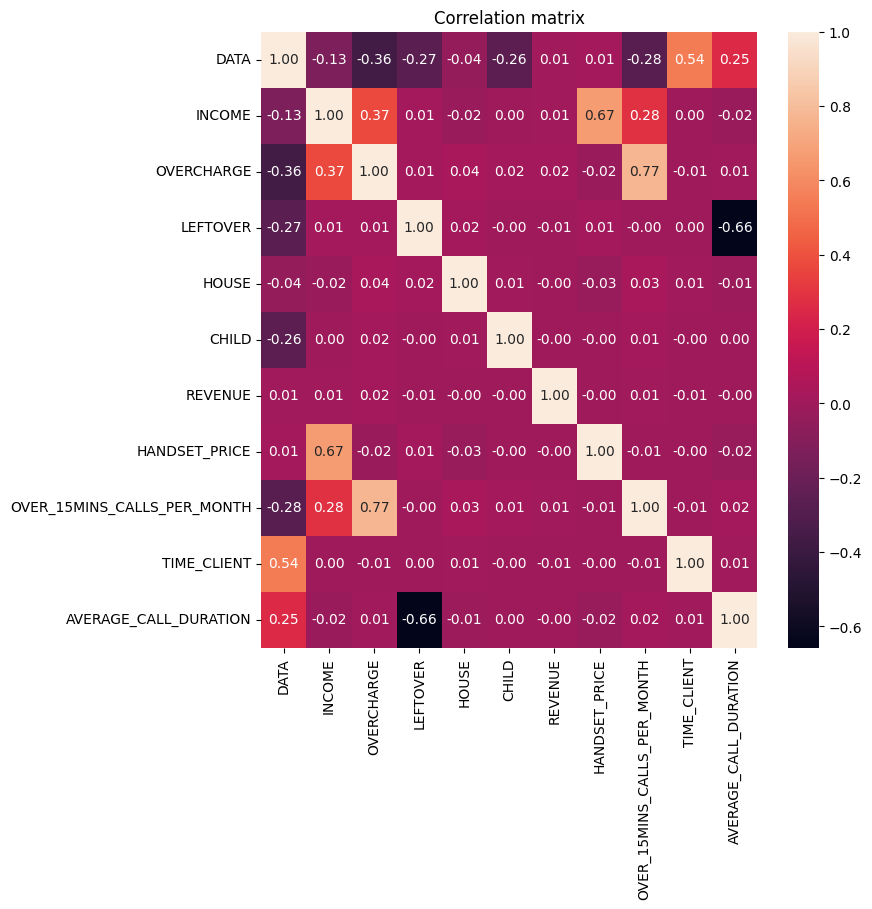

In [36]:
# quantitatives variables 
matrix = data_train[numerical_variables].corr()

plt.figure(figsize = (8,8))
sns.heatmap(matrix, annot = True, fmt = ".2f")
plt.title("Correlation matrix")
plt.show()

In [41]:
# numericals variables - density

for var in numerical_variables :

        fig = px.violin(data_train,
                                x =  var,
                                color = "CHURNED",
                                box= True
                                # points = 'all'
                                )

        fig.update_layout(title = f"{var} distribution by Churned",
                        #    template = "plotly_white",
                        width = 800,
                        height = 500
                        )
        fig.show()

## 2-2) Preprocessing

In [61]:
# categoricals variables - values transformation

data_train["COLLEGE"].replace({'zero': 0,
                               'one' : 1},
                               inplace = True)

data_train["LESSTHAN600k"].replace({False: 0,
                               True: 1},
                               inplace = True)

data_train["REPORTED_SATISFACTION"].replace({'very_unsat': 0,
                                             'unsat': 1,
                                             'avg' : 2,
                                             'sat': 3,
                                             'very_sat': 4},
                                             inplace = True)

data_train["REPORTED_USAGE_LEVEL"].replace({'very_little': 0,
                                             'little': 1,
                                             'avg' : 2,
                                             'high': 3,
                                             'very_high': 4},
                                             inplace = True)

data_train["CONSIDERING_CHANGE_OF_PLAN"].replace({'actively_looking_into_it': 0,
                                             'considering': 1,
                                             'perhaps' : 2,
                                             'no': 3,
                                             'never_thought': 4},
                                             inplace = True)
data_train["CHURNED"].replace({'STAY': 0,
                               'LEAVE' : 1},
                               inplace = True)


C:\Users\mayen\AppData\Local\Temp\ipykernel_4812\2649535452.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\mayen\AppData\Local\Temp\ipykernel_4812\2649535452.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\mayen\AppData\Local\Temp\ipykernel_4812\2649535452.py:7: FutureWarn

In [62]:
# dataset division

features = data_train.drop(columns = ["CHURNED"], axis = 1)
target = data_train["CHURNED"]

data_train_2, data_val, y_train, y_val = train_test_split(features, target, test_size= 0.2, random_state = 42 )

print("data_train_2 : ",data_train_2.shape,"\ny_train: ",y_train.shape, 
      "\ndata_val : ", data_val.shape, "\ny_val : ",y_val.shape )

data_train_2 :  (9584, 18) 
y_train:  (9584,) 
data_val :  (2397, 18) 
y_val :  (2397,)


In [87]:
# missing values 1
impute = SimpleImputer(missing_values = np.nan, strategy= "most_frequent")

cat_train= impute.fit_transform(data_train_2[categoricals_variables])
cat_test = impute.transform(data_val[categoricals_variables])

cat_train = pd.DataFrame(cat_train, columns = categoricals_variables)
cat_test = pd.DataFrame(cat_test, columns = categoricals_variables)

for var in categoricals_variables :
    cat_train[var] = cat_train[var].astype("int")
    cat_test[var] = cat_test[var].astype("int")

In [88]:
# missing values 2
impute = SimpleImputer(missing_values = np.nan, strategy= "median")

quant_train= impute.fit_transform(data_train_2[numerical_variables])
quant_test = impute.transform(data_val[numerical_variables])

quant_train = pd.DataFrame(quant_train, columns = numerical_variables)
quant_test = pd.DataFrame(quant_test, columns = numerical_variables)


In [89]:
# one hot encoding

encoder = OneHotEncoder()

cat_train2 = encoder.fit_transform(cat_train[["JOB_CLASS"]])
cat_test2= encoder.transform(cat_test[["JOB_CLASS"]])

variables = encoder.get_feature_names_out()
cat_train2 = pd.DataFrame(cat_train2.toarray(), columns =variables )
cat_test2 = pd.DataFrame(cat_test2.toarray(), columns =variables )

for var in variables :
    cat_train2[var] = cat_train2[var].astype("int")
    cat_test2[var] = cat_test2[var].astype("int")


In [90]:
# final categorical data
var2 = [var for var in categoricals_variables if var != "JOB_CLASS"]

cat_train_f = pd.concat([cat_train[var2], cat_train2], axis = 1)
cat_test_f = pd.concat([cat_test[var2], cat_test2], axis = 1)

In [93]:
# final dataset for ML

data_train_final = pd.concat([quant_train, cat_train_f], axis = 1)
data_val_final = pd.concat([quant_test, cat_test_f], axis = 1)

print(data_train_final.shape)
print(data_val_final.shape)

(9584, 20)
(2397, 20)


**Changement du type des variables catégorielles** 

In [94]:
news_variables_cat = cat_train_f.columns.to_list()

for var in news_variables_cat :
    data_train_final[var] = data_train_final[var].astype("category")
    data_val_final[var] = data_val_final[var].astype("category")    

data_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9584 entries, 0 to 9583
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   DATA                         9584 non-null   float64 
 1   INCOME                       9584 non-null   float64 
 2   OVERCHARGE                   9584 non-null   float64 
 3   LEFTOVER                     9584 non-null   float64 
 4   HOUSE                        9584 non-null   float64 
 5   CHILD                        9584 non-null   float64 
 6   REVENUE                      9584 non-null   float64 
 7   HANDSET_PRICE                9584 non-null   float64 
 8   OVER_15MINS_CALLS_PER_MONTH  9584 non-null   float64 
 9   TIME_CLIENT                  9584 non-null   float64 
 10  AVERAGE_CALL_DURATION        9584 non-null   float64 
 11  COLLEGE                      9584 non-null   category
 12  LESSTHAN600k                 9584 non-null   category
 13  REP

In [96]:
pd.isnull(data_val_final).sum()

DATA                           0
INCOME                         0
OVERCHARGE                     0
LEFTOVER                       0
HOUSE                          0
CHILD                          0
REVENUE                        0
HANDSET_PRICE                  0
OVER_15MINS_CALLS_PER_MONTH    0
TIME_CLIENT                    0
AVERAGE_CALL_DURATION          0
COLLEGE                        0
LESSTHAN600k                   0
REPORTED_SATISFACTION          0
REPORTED_USAGE_LEVEL           0
CONSIDERING_CHANGE_OF_PLAN     0
JOB_CLASS_1                    0
JOB_CLASS_2                    0
JOB_CLASS_3                    0
JOB_CLASS_4                    0
dtype: int64

# 3-) Machine learning

## 3-1) Model 1 : Logistic Regression

## 3-2) Model 2 : Random Forest

In [42]:
# Entraînement model de Random Forest

rf_model = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [43]:
# prédictions 

y_pred = rf_model.predict(X_test)

In [49]:
y_pred_proba = rf_model.predict_proba(X_test)[:,1]

L'aire sous la courbe ROC **(AUC)** est une mesure de la performance d'un modèle de classification binaire. Sur les résultats suivant, nous voyons que l'AUC = 0.841719.  

Ce score est un bon résultat parce que plus l'AUC est proche de 1 plus un modèle à une bonne capacité à discriminer entre les classes positives et négatives et c'est le cas pour notre modèle

In [50]:
# Calculer l'AUC
auc_value = roc_auc_score(y_test, y_pred_proba)
print(f"AUC : {auc_value}")


AUC : 0.8417190513369768


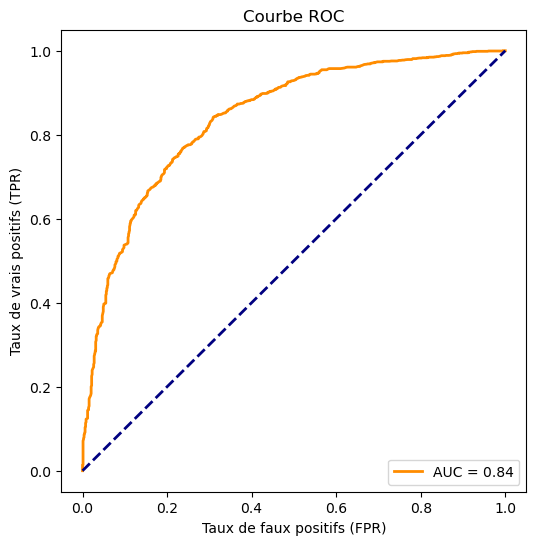

In [51]:
# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_value:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

**Variables d'importances**

In [232]:
# Obtenir les variables d'importance
importances = rf_model.feature_importances_

# Créer un DataFrame pour visualiser les variables d'importance
feature_importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importance': importances
})

# Trier le DataFrame par ordre d'importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Afficher les variables d'importance
feature_importance_df

,Variable,Importance
5,HOUSE,0.103408
1,DATA,0.103099
2,INCOME,0.093664
3,OVERCHARGE,0.081665
9,HANDSET_PRICE,0.077450
11,TIME_CLIENT,0.065836
8,REVENUE,0.062296
10,OVER_15MINS_CALLS_PER_MONTH,0.060867
4,LEFTOVER,0.060547
12,AVERAGE_CALL_DURATION,0.044152


**Commentaires :** Nous constatons que les variables les plus importantes dans la prediction de notre model sont :

Celles-ci jouent donc un rôle déterminant dans l'explication du désabonement des clients de l'entreprise TELCO

**Optimisation à l'aide de la GridSearchCV**

In [168]:
import numpy as np
np.sqrt(len(X_train.columns))

5.656854249492381

In [78]:
# optimisation du modèle à l'aide de la GridSearchCV

# Instancier le modèle de Random Forest
rf_model2 = RandomForestClassifier(random_state=42)

# Définir la grille des hyperparamètres à rechercher
param_grid = {
    'max_depth': [None,5, 10, 20],
    'n_estimators': [200,500, 800,1000],  # Essayez différentes valeurs pour le nombre d'arbres
    'max_features': [2,5,8,10]  # Essayez différentes valeurs pour le nombre de variables à considérer
}

# Instancier GridSearchCV
grid_search = GridSearchCV(estimator=rf_model2, param_grid=param_grid, scoring='roc_auc', cv=5)

# Ajuster le modèle aux données d'entraînement avec recherche d'hyperparamètres
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 10, 20],
                         'max_features': [2, 5, 8, 10],
                         'n_estimators': [200, 500, 800, 1000]},
             scoring='roc_auc')

In [79]:
# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Afficher la meilleure performance (AUC)
print("Meilleure performance (AUC) :", grid_search.best_score_)

Meilleurs hyperparamètres : {'max_depth': None, 'max_features': 10, 'n_estimators': 1000}
Meilleure performance (AUC) : 0.8448017563156658


Le model *rf_model2* nous donne un meilleur score AUC que celui utilsé précedemment. Nous utiliserons donc celui-ci par la suite.

In [80]:
# Entraînement du 2e modèle

rf_model2 = RandomForestClassifier(max_depth = None, max_features = 10, n_estimators = 1000, random_state = 42)

rf_model2.fit(X_train, y_train)

RandomForestClassifier(max_features=10, n_estimators=1000, random_state=42)

In [83]:
y_pred_proba2 = rf_model2.predict_proba(X_test)[:,1]

# Calculer l'AUC
auc_value = roc_auc_score(y_test, y_pred_proba2)
print(f"AUC : {auc_value}")


AUC : 0.8434645118883173


## 3-3 ) Model 3 : XGBoost

## 3-4) Model 4 : LGBM